In [1]:
import argparse
import os
import random

import numpy as np
import torch
import torch.backends.cudnn as cudnn
import gradio as gr

from minigpt4.common.config import Config
from minigpt4.common.dist_utils import get_rank
from minigpt4.common.registry import registry
from minigpt4.conversation.conversation import Chat, CONV_VISION
from PIL import Image
# imports modules for registration
from minigpt4.datasets.builders import *
from minigpt4.models import *
from minigpt4.processors import *
from minigpt4.runners import *
from minigpt4.tasks import *
from datasets import load_dataset
from tqdm import tqdm
from matplotlib import pyplot as plt
import json
from textwrap import wrap
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry
import cv2

from scipy.ndimage.filters import gaussian_filter

/work/ossowski/anaconda3/envs/minigpt4/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_2141518/560735487.py:29: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


In [85]:
sam = sam_model_registry["default"](checkpoint="/data/ossowski/Segment_Anything/sam_vit_h_4b8939.pth")
mask_generator = SamAutomaticMaskGenerator(sam, points_per_side = 30, pred_iou_thresh=0.88, box_nms_thresh=0.9)
num = 16
image_num = 0

image = cv2.imread(f"../raw_images/{num * 2 + image_num}.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
masks = mask_generator.generate(image)
sorted_anns = sorted(masks, key=(lambda x: x['area']), reverse=True)




In [86]:
# masks = range(len(sorted_anns))

visited = np.zeros_like(sorted_anns[0]['segmentation'])
h, w= visited.shape
# Only keep mask if it contains unique pixels
masks = []
cutoff = 500
for i, mask in enumerate(sorted_anns):
    print(mask['area'], h * w * 0.5)
    #if mask['area'] < 10000 or mask['area'] > h * w * 0.5:
    if mask['area'] < 10000:

        continue
    bool_mask = mask['segmentation']
    visited_copy = visited.copy()
    unique = True
    total_overlap = 0
    for j in range(len(bool_mask)):
        for k in range(len(bool_mask[0])):
            if visited_copy[j,k] == 1 and bool_mask[j,k] == 1:
                total_overlap += 1
                if total_overlap > cutoff:
                    unique = False

                    break
            elif visited_copy[j,k] == 0 and bool_mask[j,k] == 1:
                visited_copy[j,k] = 1
        if not unique:
            break
    if unique:
        visited = visited_copy
        masks.append(i)
print(masks)

1953566 1520640.0
186907 1520640.0
175688 1520640.0
174811 1520640.0
174661 1520640.0
174248 1520640.0
143911 1520640.0
143625 1520640.0
143374 1520640.0
120225 1520640.0
101447 1520640.0
100245 1520640.0
97157 1520640.0
92580 1520640.0
87660 1520640.0
78479 1520640.0
78168 1520640.0
76612 1520640.0
76239 1520640.0
76102 1520640.0
75828 1520640.0
72082 1520640.0
71643 1520640.0
65976 1520640.0
61432 1520640.0
59766 1520640.0
44204 1520640.0
42429 1520640.0
40277 1520640.0
39599 1520640.0
34252 1520640.0
33390 1520640.0
32992 1520640.0
32896 1520640.0
32443 1520640.0
32160 1520640.0
29364 1520640.0
25906 1520640.0
21040 1520640.0
17663 1520640.0
15272 1520640.0
13838 1520640.0
13176 1520640.0
9235 1520640.0
7682 1520640.0
6311 1520640.0
5130 1520640.0
[0, 1, 2, 6, 9, 10, 15, 17, 19]


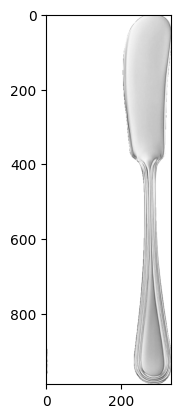

In [87]:
os.makedirs("test", exist_ok=True)

for k in range(len(masks)):
    bool_mask = sorted_anns[masks[k]]['segmentation']
    x1, x2, y1, y2 = len(bool_mask), 0, len(bool_mask[0]), 0
    for i in range(len(bool_mask)):
        for j in range(len(bool_mask[0])):
            if bool_mask[i][j] == 1:
                x1 = min(x1, i)
                x2 = max(x2, i)
                y1 = min(y1, j)
                y2 = max(y2, j)
    test = Image.open(f"../raw_images/{num * 2 + image_num}.png").convert('RGB')

    im_copy  = np.array(test)

    im_copy[~bool_mask] = np.array([255,255,255])
    cropped = np.array(Image.fromarray(im_copy).crop((y1, x1, y2, x2)))

    # m = np.zeros((max(np.array(cropped).shape), max(np.array(cropped).shape), 3), dtype=np.uint8)
    # if np.array(cropped).shape[0] <= np.array(cropped).shape[1]:
    #     offset = abs(x2 - x1) // 2
    #     start = m.shape[0] // 2 - offset 
    #     m[start:start + x2 - x1, :, :] = np.array(cropped)
    # else:
    #     offset = (y2 - y1) // 2
    #     start = m.shape[1] // 2 - offset
    #     m[:, start:start+y2 - y1, :] = np.array(cropped)

    plt.imshow(cropped)
    plt.savefig(f"test/test{k}.png")
#plt.imsave("test.png")


In [ ]:
()